In [124]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import get_data
import plotly.express as px

In [2]:
df = pd.read_sql_query('SELECT datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq FROM quarterly',get_data.engine)
#dlttq: total long term debt, 
#lseq: 
#ltq: Liabilities (Total)
df.head()
# Debt to equity ratio = dlttq / seqq

,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq
0,2013-06-30,028967,QCRH,74727A104,392.804,2446.771,145.446,2301.325
1,2013-09-30,028967,QCRH,74727A104,388.253,2485.714,147.953,2337.761
2,2013-12-31,028967,QCRH,74727A104,338.238,2394.953,147.577,2247.376
3,2014-03-31,028967,QCRH,74727A104,418.274,2426.319,141.357,2284.962
4,2014-06-30,028967,QCRH,74727A104,414.709,2464.839,134.643,2330.196


In [3]:
df['debt_to_equity'] = df['dlttq'] / df['seqq']
df.head()

,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,debt_to_equity
0,2013-06-30,028967,QCRH,74727A104,392.804,2446.771,145.446,2301.325,2.700686
1,2013-09-30,028967,QCRH,74727A104,388.253,2485.714,147.953,2337.761,2.624164
2,2013-12-31,028967,QCRH,74727A104,338.238,2394.953,147.577,2247.376,2.291943
3,2014-03-31,028967,QCRH,74727A104,418.274,2426.319,141.357,2284.962,2.958990
4,2014-06-30,028967,QCRH,74727A104,414.709,2464.839,134.643,2330.196,3.080064


inf -12316.5


<AxesSubplot:ylabel='Frequency'>

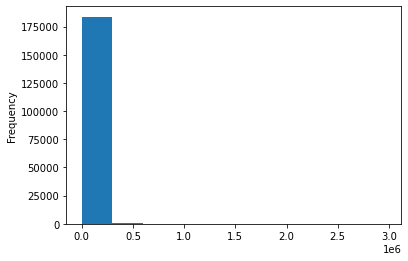

In [4]:
print(max(df['debt_to_equity']), min(df['debt_to_equity']))
df['ltq'].plot(kind='hist')

4615.695451040863 1.3351776587392717e-06


<AxesSubplot:ylabel='Frequency'>

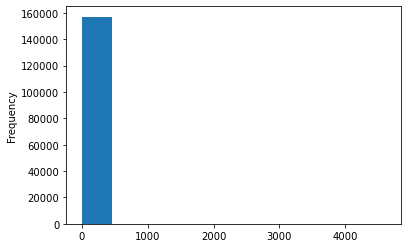

In [5]:
# Filter out rows with negative values in dlttq, seqq, or 0
filtered_df = df[(df['dlttq'] > 0) & (df['seqq'] > 0)]
filtered_df.head()
print(max(filtered_df['debt_to_equity']), min(filtered_df['debt_to_equity']))
filtered_df['debt_to_equity'].plot(kind='hist')

968.3087761674718 1.3351776587392717e-06


,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,debt_to_equity
194942,2012-06-30,028967,QCRH,74727A104,378.071,2043.426,136.907,1904.104,2.761517
194943,2012-09-30,028967,QCRH,74727A104,370.673,2023.946,138.975,1884.825,2.667192
194944,2012-12-31,028967,QCRH,74727A104,347.075,2093.730,140.434,1953.296,2.471446
194945,2013-03-31,028967,QCRH,74727A104,379.677,2143.991,142.198,2001.793,2.670059
194946,2001-12-31,029359,SUI,866674104,477.598,994.449,329.641,521.810,1.448843


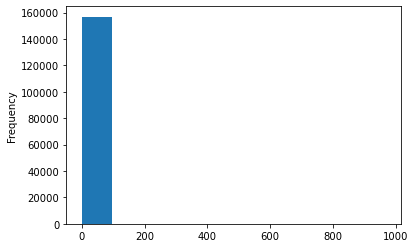

In [6]:
# truncating the ratio to only include rows under 100 (realistically we probably want an even lower ratio)
filtered_df = filtered_df[(filtered_df['debt_to_equity'] < 1000)]
print(max(filtered_df['debt_to_equity']), min(filtered_df['debt_to_equity']))
filtered_df['debt_to_equity'].plot(kind='hist')
filtered_df.tail()

In [65]:
returns_df = pd.read_sql_query('SELECT date,cusip,ticker,ret,prc,askhi,bidlo FROM returns', get_data.engine)
returns_df.head()

,date,cusip,ticker,ret,prc,askhi,bidlo
0,2000-01-28,72913210,PLXS,-0.015883,50.3438,50.875,49.25
1,2000-01-31,72913210,PLXS,-0.076350,46.5000,50.375,46.50
2,2000-02-28,72913210,PLXS,0.004324,58.0625,59.125,57.75
3,2000-02-29,72913210,PLXS,-0.027449,56.4688,57.875,52.50
4,2000-03-28,72913210,PLXS,0.026616,67.5000,69.000,65.00


In [55]:
print(returns_df['ticker'].nunique())

4094


4093


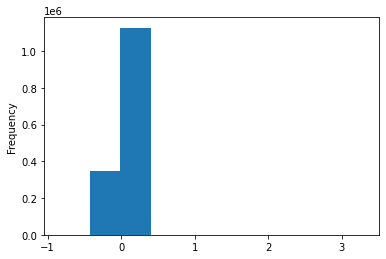

In [56]:
returns_df['ret'] = pd.to_numeric(returns_df['ret'], errors='coerce')
returns_df.dropna(subset=['ret'], inplace=True)
returns_df['ret'].plot(kind='hist')
print(returns_df['ticker'].nunique())

In [57]:
filtered_df['datadate'].min()
filtered_df.tail()

,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,debt_to_equity
194942,2012-06-30,028967,QCRH,74727A104,378.071,2043.426,136.907,1904.104,2.761517
194943,2012-09-30,028967,QCRH,74727A104,370.673,2023.946,138.975,1884.825,2.667192
194944,2012-12-31,028967,QCRH,74727A104,347.075,2093.730,140.434,1953.296,2.471446
194945,2013-03-31,028967,QCRH,74727A104,379.677,2143.991,142.198,2001.793,2.670059
194946,2001-12-31,029359,SUI,866674104,477.598,994.449,329.641,521.810,1.448843


In [113]:
buy_trades, sell_trades = [] , []
for d in filtered_df['datadate'].unique():
  temp = filtered_df[filtered_df['datadate'] == d]
  quntile_nbr = int(len(temp) / 5.0)
  buy_trades.append(temp.sort_values('debt_to_equity', ascending=False).head(quntile_nbr))
  sell_trades.append(temp.sort_values('debt_to_equity', ascending=True).head(quntile_nbr))

df_buy_trades = pd.concat(buy_trades)
df_buy_trades['trade'] = 'buy'
df_sell_trades = pd.concat(sell_trades)
df_sell_trades['trade'] = 'sell'
df_buy_trades.head()
print(df_buy_trades.size)
print(df_sell_trades.size)

313020
313020


<AxesSubplot:xlabel='datadate'>

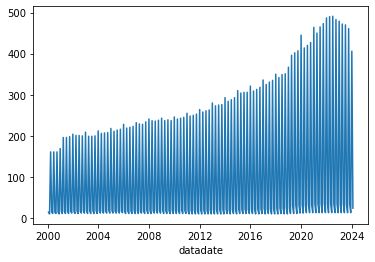

In [102]:
df_buy_trades.groupby('datadate')['cusip'].size().plot(kind='line')

<AxesSubplot:xlabel='datadate'>

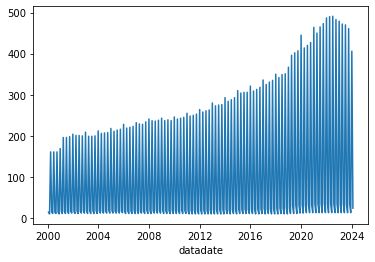

In [103]:
df_sell_trades.groupby('datadate')['cusip'].size().plot(kind='line')

In [115]:
returns_df['date'] = pd.to_datetime(returns_df['date'])
df_buy_trades['datadate'] = pd.to_datetime(df_buy_trades['datadate'])
df_sell_trades['datadate'] = pd.to_datetime(df_sell_trades['datadate'])

df_buy_trades = df_buy_trades.sort_values(by='datadate')
df_sell_trades = df_sell_trades.sort_values(by='datadate')
returns_df = returns_df.sort_values(by='date')

In [123]:
window = 90
# Merge buy and sell trades dataframes with returns dataframe
merged_buy = pd.merge(df_buy_trades, returns_df, left_on=['datadate', 'tic'], right_on=['date', 'ticker'], how='left')
merged_sell = pd.merge(df_sell_trades, returns_df, left_on=['datadate', 'tic'], right_on=['date', 'ticker'], how='left')
# merged_buy.head()

# Shift prices for the next day for buy trades
merged_buy['prc_next_day'] = merged_buy.groupby('tic')['prc'].shift(-1)

# Shift prices for the next day for sell trades
merged_sell['prc_next_day'] = merged_sell.groupby('tic')['prc'].shift(-1)

# Calculate returns for buy trades
merged_buy['return'] = (merged_buy['prc_next_day'] - merged_buy['prc']) / merged_buy['prc']

# Calculate returns for sell trades
merged_sell['return'] = (merged_sell['prc_next_day'] - merged_sell['prc']) / merged_sell['prc']

merged_buy = merged_buy.dropna(subset=['return'])
merged_sell = merged_sell.dropna(subset=['return'])

# Concatenate buy and sell trades
all_trades = pd.concat([merged_buy, merged_sell])


# Analyze returns
total_return = all_trades.groupby('trade')['return'].sum()

print("\nTotal Return:")
print(total_return)


Total Return:
trade
buy      481.342219
sell    1129.159659
Name: return, dtype: float64


In [126]:
fig = px.box(all_trades, x='trade', y='return')
fig.show()